# Biodiversity Intactness Index Change in Pheonix Subdivision

Author: Benjamin Versteeg

Repository: https://github.com/BenVerst/Biodiversity-Intactness-Index-in-Phoenix-Subdivision

## About
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001. Urban sprawl creates pressure on biodiversity and natural areas. 

### Purpose
This notebook will explore a dataset showing values for a biodiversity intactness index (BII) to find changes in this BII around the Phoenix area from 2017 to 2020. 

### Highlights

- Accessing Data from MPC STAC catalog.
- Data Visualization
- Statistical Analysis

### Data

- Biodiversity Intactness Index dataset from the Microsoft Planetary Computer(MPC), SpatioTemporal Asset Catalog (STAC) Catalog

- Census County Subdivision Arizona TIGER shapefile https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

## Import Libraries

In [10]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import pandas as pd
import os

from shapely.geometry import Polygon

from pystac_client import Client

import planetary_computer

import contextily as ctx

from IPython.display import Image

## Data Search
### The `io-biodiversity` collection

In [11]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [12]:
# make a bbox using Pheonix Subdivision coords
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]


# search 
search = catalog.search(
    collections=["io-biodiversity"],
    bbox = bbox,
    datetime = "2017/2020" # time range
)

In [13]:
# get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

# subset for item in 2020
i_2020 = items[0]
# subset for item in 2017
i_2017 = items[3]

There are 4 items in the search.


### Pheonix County Data

In [14]:
# read in Arizona counties shapefile
a_counties =gpd.read_file(os.path.join('data', 'tl_2022_04_cousub.shp'))
a_counties.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


In [15]:
# select only Phoenix
phoenix = a_counties[a_counties.NAME == "Phoenix"]

phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,NaN,NaN,NaN,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


## Phoenix Subdivision Map

<Axes: >

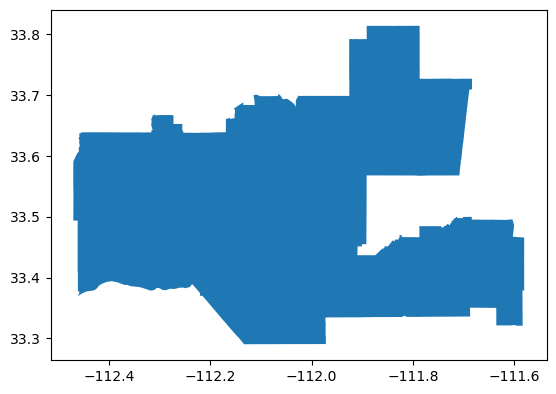

In [16]:
phoenix.plot()

<Axes: title={'center': 'Phoenix County, Arizona'}>

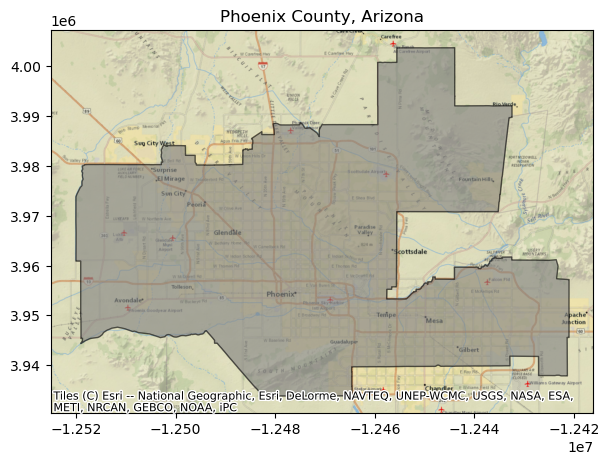

In [17]:
#create a Pheonix County map
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(7, 7), 
            alpha=0.6,
            color = "grey",
            edgecolor="k")
      )

# add basemap from NatGeo
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# add title
ax.set_title('Phoenix County, Arizona')

ax

## Percentage of Area of the Phoenix Subdivision
### BII of .75 (2017, 2020)

In [18]:
# Rendered preview
Image(url = i_2020.assets['rendered_preview'].href, width = 300)

### Prepare Data

In [19]:
# rasters for phoenix 2020 and 2017
ph_2020 = rioxr.open_rasterio(i_2020.assets['data'].href)
ph_2017 = rioxr.open_rasterio(i_2017.assets['data'].href)

# update phoenix geometry
ph_crs = phoenix.to_crs(ph_2020.rio.crs)

# check the crs
ph_crs.crs == ph_2020.rio.crs

True

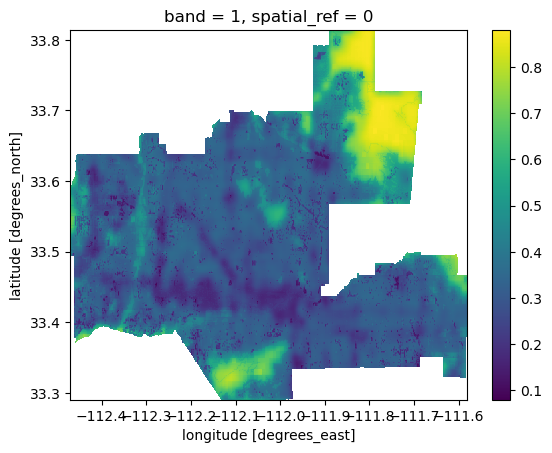

In [20]:
# clip rasters to get phoenix shape
ph_20 = ph_2020.rio.clip(ph_crs['geometry'])
ph_17 = ph_2017.rio.clip(ph_crs['geometry'])

ph_20.plot()

In [21]:
# select only values greater than 0.75
ph_20_75 = ph_20>=0.75
ph_17_75 = ph_17>=0.75

# check raster
ph_20_75

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

In [22]:
# update type to integer
ph_20_75 = ph_20_75.astype(int)
ph_17_75 = ph_17_75.astype(int)

# check
ph_20_75

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

### Calculate the Percentage of Area
BII of .75 (2017, 2020)

In [23]:
# percent of pixels calculation
ph_20_perc = (ph_20_75.sum().item()) / (ph_20_75.count().item())* 100
ph_17_perc = (ph_17_75.sum().item()) / (ph_17_75.count().item())* 100

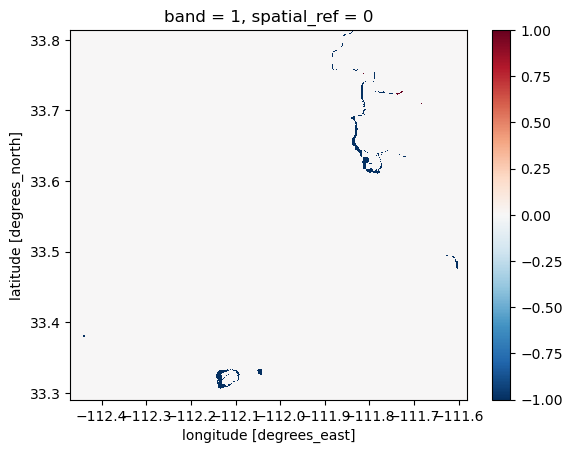

In [24]:
# change in area calculation
ph_20_17 = ph_20_75 - ph_17_75

ph_20_17.plot()

In [25]:
# percent of pixels calculation again
ph_20_17_perc = (ph_20_17.sum().item() / ph_20_17.count().item())*100

#check
ph_20_17_perc

-0.3719874560354835

In [26]:
# update so values with -1 become na
ph_change = ph_20_17.where(ph_20_17 == -1)
ph_change

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

## Plotting the Change in Area of 2017 & 2020 (BII >= .75)

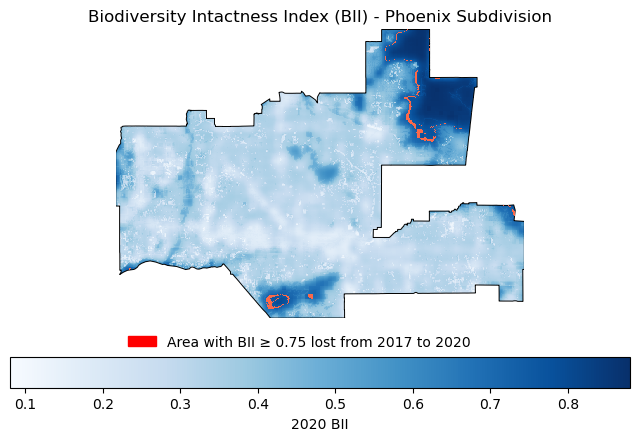

In [27]:
# add basemap
fig, ax = plt.subplots(figsize = (8,5))
ax.axis('off') # remove axis

# plot 2020 values
ph_20_plot = ph_20.plot(ax=ax,
                      cmap = "Blues", # color
                      add_colorbar = False) # remove color bar

# area outline
phoenix.plot(ax=ax,
             facecolor="none", # remove main color
             edgecolor="black", # edge color
             linewidth=0.7)

# plot lost area
ph_change.plot(ax=ax, 
          cmap = 'Reds', # makes color map visible ontop of phoenix plot
          add_colorbar=False) # remove color bar 


# add title 
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix Subdivision")

# create legend with legend text
patch = mpatches.Patch(color='red', label='Area with BII ≥ 0.75 lost from 2017 to 2020')

# add legend to map
ax.legend(handles=[patch],
          frameon=False,
          bbox_to_anchor= (0, -0.15),
          loc = 'lower left')

# create color bar
fig.colorbar(ph_20_plot, 
             orientation="horizontal", # horizontal orientation
             pad=0.1, # position color bar 
             label = "2020 BII")